<a href="https://colab.research.google.com/github/Nadiam75/DeepLearning_HW_2/blob/main/deepPose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import progressbar
import tensorflow as tf
import scipy




!rm -d -f -r rm *.zip
!rm -d -f -r rm *.npy


!rm -rf images
!rm -rf visualized


In [3]:
!wget -nc https://github.com/Nadiam75/DeepLearning_HW_2/raw/main/lsp_dataset/joints.mat
joints=scipy.io.loadmat('joints.mat')['joints']
# poses = joints [0:2 , : , :]
poses = joints

!wget  -nc https://github.com/Nadiam75/DeepLearning_HW_2/raw/main/lsp_dataset/images.zip
!unzip -q /content/images.zip


File ‘joints.mat’ already there; not retrieving.

--2021-12-13 19:45:26--  https://github.com/Nadiam75/DeepLearning_HW_2/raw/main/lsp_dataset/images.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Nadiam75/DeepLearning_HW_2/main/lsp_dataset/images.zip [following]
--2021-12-13 19:45:26--  https://raw.githubusercontent.com/Nadiam75/DeepLearning_HW_2/main/lsp_dataset/images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10319538 (9.8M) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]   9.84M  --.-KB/s    in 0.1s    

2021-12-13 19:45:28 (82.1 MB/s) 

(201, 145, 3)


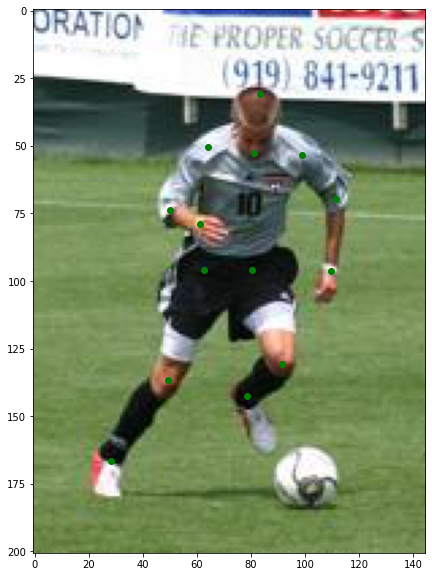

In [4]:

iii = 1

image = plt.imread(f'images/im000{iii+1}.jpg')

print(image.shape)
plt.figure(figsize=(10,10))
plt.imshow(image)
jj = joints [0:2 , : , iii]
plt.scatter(joints [0, : , iii],joints [1 , : , iii],c='g',label='Predicted')




In [211]:
joints [0 , : , iii]


array([ 28.12031897,  49.17944312,  62.60463477,  80.24165125,
        91.56093048,  78.39897788,  61.28843951,  49.96916028,
        63.92083003,  98.66838488, 111.30385937, 109.46118601,
        81.0313684 ,  83.40051987])

In [212]:
joints [1, : , iii]

array([166.65510177, 136.64584985,  95.84379681,  96.10703586,
       130.85459071, 142.70034805,  78.99649749,  73.73171645,
        50.56667988,  53.46230945,  69.78313067,  96.37027491,
        52.6725923 ,  30.82375099])

In [176]:
joints [0, : , iii]

array([117.43859932,  90.30722578,  89.53935671,  76.48558265,
        52.93759806,  33.48491514,  62.15202681,  78.02132077,
        84.42022963,  66.75924119,  70.34263015,  58.05672514,
        75.20580088,  75.97366994])

In [146]:
height,width=image.shape[0],image.shape[1]
print(height)
print(width)

170
91


In [5]:

images_directory=os.listdir('/content/images')
target_size=(220,220)
resized_images=[]
resized_poses=[]
original_scale=[]
originalImages = []
dictionaryOfTrainImages = {}
dictionaryOfTestImages = {}
dictionaryOfImages = {}
# datasetDictionary = {}
for idx,x in progressbar.progressbar(enumerate(images_directory)):
    if idx+1 < 10 :  
      path = f'/content/images/im000{idx+1}.jpg'
    if idx+1>=10 and idx <100:
      path = f'/content/images/im00{idx+1}.jpg'
    if idx+1 >= 100 and idx <= 999 :
      path = f'/content/images/im0{idx+1}.jpg'
    if idx+1 >= 1000:
      path = f'/content/images/im{idx+1}.jpg'


    
    image = plt.imread(path)
    dictionaryOfImages [idx ] = image

    width, height=image.shape[0],image.shape[1]
    # print(height)
    # print(width)
    # print(idx)
    if  np.any (poses[0,:,idx] > height ):
      print("height " , idx)
    if np.any (poses [1,:,idx] > width ):
      print("width" , idx)
    # resized_poses(height/2)
    # scale_w,scale_h=220/width,220/height
    # original_scale.append([width,height])
    # originalImages.appned(image)
    # resized_poses.append(   [poses[0,:,idx]*scale_w*2-1                 ,       poses[1,:,idx]*scale_h*2-1   ]   )
    # resized_poses.appned (  [   (poses[0,:,idx] - width/2 )/ width * 2  , (poses[1,:,idx]-height/2) /height*2 ]   )

    resized_poses.append(  [ poses[0,:,idx]*220 / height ,    poses[1, : , idx]  *220/ width ])
    # if idx == 1:
    #   print("esjkgk")
    #   print (" width" , width)
    #   print (poses[0,:,idx])
    #   print( poses[0,:,idx]*220 / height)

    #   print (" height " , height)
    #   print (poses[1, : , idx])
    #   print (  poses[1, : , idx]  *220/ width)




    image=cv2.resize(image,target_size,interpolation=cv2.INTER_AREA)
    resized_images.append(image)


resized_images=np.array(resized_images)


# print(resized_images.shape)
resized_poses=np.array(resized_poses)
# print(resized_poses.shape)
original_scale=np.array(original_scale)

# print(original_scale.shape)

trainkeys = np.arange(0 , 1600)
trainDict = {k: dictionaryOfImages[k] for k in trainkeys}

testkeys = np.arange(1600 , 2000)
testDict = {k: dictionaryOfImages[k] for k in testkeys}


np.save('Leeds Sports Dataset NPY.npy',resized_images[:1600])
np.save('Resized Poses.npy',resized_poses[:1600])
np.save('Image scale.npy',original_scale[:1600])
np.save('Leeds Sports Dataset NPY Test.npy',resized_images[1600:])
np.save('Resized Poses Test.npy',resized_poses[1600:])
np.save('Image scale Test.npy',original_scale[1600:])


!rm -d -f -r rm *.zip


| |   #                                             | 247 Elapsed Time: 0:00:00

width 125


| |                         #                      | 1999 Elapsed Time: 0:00:02


In [6]:

x_train = resized_images[:1600]
y_train = resized_poses[:1600]
train_reconstruction_coefficient = original_scale[:1600]


x_test = resized_images[1600:]
y_test = resized_poses[1600:]
test_reconstruction_coefficient  =original_scale[1600:]

In [149]:
# def define_model(self):
#   #Changes made on model architecture
#   #LRN->BN, Pooling->Strided Convolution
#   model=tf.keras.models.Sequential()
#   model.add(tf.keras.layers.Conv2D(48,11,(4,4),padding='same',input_shape=(220,220,3)))
#   model.add(tf.keras.layers.BatchNormalization())
#   model.add(tf.keras.layers.ReLU())
#   model.add(tf.keras.layers.Conv2D(128,5,(2,2),padding='same'))
#   model.add(tf.keras.layers.BatchNormalization())
#   model.add(tf.keras.layers.ReLU())
#   model.add(tf.keras.layers.Conv2D(192,3,(2,2),padding='same',activation='relu'))
#   model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
#   model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
#   model.add(tf.keras.layers.MaxPooling2D())
#   model.add(tf.keras.layers.Flatten())
#   model.add(tf.keras.layers.Dense(4096,activation='relu'))
#   model.add(tf.keras.layers.Dropout(0.4))
#   model.add(tf.keras.layers.Dense(4096,activation='relu'))
#   model.add(tf.keras.layers.Dropout(0.4))
#   model.add(tf.keras.layers.Dense(28,activation='linear'))
#   return model

In [7]:
class DatasetManager():
  def __init__(self,dataset_name):
    self.data=self.load_dataset('lsp')
    # print(len(self.data))
    # return self.data
  def load_dataset(self,name):
    if name=='lsp':
      df=dict()
      df['images']=2*x_train/255.0 -1
      df['poses']=self.to_relative_coord(y_train, 220)
      #df['scale']=np.load('/content/drive/My Drive/data/Pose Estimation/LSP-Extended/Image scale.npy')
      # df['poses']=self.to_relative_coord(y_train,220)

      df['scale train'] = train_reconstruction_coefficient

      df['test images']=2*x_test/255.0 -1
      df['test poses']=self.to_relative_coord(y_test , 220)
      #df['test scale']=np.load('/content/drive/My Drive/data/Pose Estimation/LSP-Extended/Image scale Test.npy')
      df ['scale test '] = test_reconstruction_coefficient
      return df

  def compare_pose(self,index,model,test):
    selected = dictionaryOfImages[1600+index]
    w   =   selected.shape[0]
    h   =   selected.shape[1]

    # show predicted
    if test:
      print('predicted')
      predicted_pose=self.to_absolute_coord(model.model.predict(self.data['test images'][index:index+1]),220)
    else:
      predicted_pose=self.to_absolute_coord(model.model.predict(self.data['images'][index:index+1]),220)
    pose_width,pose_height=predicted_pose[0][:14]*h/220  ,predicted_pose[0][14:]*w/220
    plt.figure(figsize=(10,10))

# show image

    if test:
      # plt.imshow(np.uint8 ( (self.data['test images'][index: index+1]  + 1 )*255   ) [0]   ) 
      # plt.imshow(testDict[1600+index])
      # plt.imshow(x_test[index] )
      plt.imshow(dictionaryOfImages[1600+index] )

    else:
      # plt.imshow(dictionaryOfImages[1600+index] )
      # plt.imshow(trainDict[index])
      plt.imshow(x_train[index] )

    plt.scatter(pose_width,pose_height,c='g',label='Predicted')



    if test:
      print('actual')
      plt.scatter(joints[0 , :  , 1600 + index],   joints[1, :  , 1600 +  index],c='r',label='True')
    else:
      plt.scatter(self.to_absolute_coord(dataset.data['poses'][1600 + index][0],220),self.to_absolute_coord(dataset.data['poses'][1600 +index][1],220),c='r',label='True')
    # if test:
    #   print('actual')
    #   plt.scatter(self.to_absolute_coord(dataset.data['test poses'][index][0],220),self.to_absolute_coord(dataset.data['test poses'][index][1],220),c='r',label='True')
    # else:
    #   plt.scatter(self.to_absolute_coord(dataset.data['poses'][index][0],220),self.to_absolute_coord(dataset.data['poses'][index][1],220),c='r',label='True')
    plt.legend()
    plt.show()

  def augment_images(self):
    new_images=[]
    new_poses=[]
    for idx in progressbar.progressbar(range(self.data['poses'].shape[0])):
      x,y=self.data['poses'][idx][0],self.data['poses'][idx][1]
      image=self.data['images'][idx]
      #Flip image at 50%
      if np.random.randint(2)==1:
        image=np.fliplr(image)
        x=-x
      if np.random.randint(2)==1:
        image=np.flipud(image)
        y=-y

      #transform image
      #transformation_scale=np.array([np.random.rand()*2-1,np.random.rand()*2-1,0])*0.4
      #image=scipy.ndimage.shift(image,(transformation_scale*220).astype(int),mode='nearest')
      x+=transformation_scale[0]*2
      y+=transformation_scale[1]*2

      new_images.append(image)
      new_poses.append(np.array([x,y]))

    return np.array(new_images),np.array(new_poses)





  def test_pdj(self,model,joint_index):
    joint_index=['Right elbow','Right wrist']
    name2index={'Right ankle':0,
    'Right knee':1,
    'Right hip':2,
    'Left hip':3,
    'Left knee':4,
    'Left ankle':5,
    'Right wrist':6,
    'Right elbow':7,
    'Right shoulder':8,
    'Left shoulder':9,
    'Left elbow':10,
    'Left wrist':11,
    'Neck':12,
    'Head top':13}
    min_d,max_d=0,1
    pred=model.model.predict(self.data['test images'])
    true=self.data['test poses']

    pred_x,pred_y=pred[:,:14],pred[:,14:]
    true_x,true_y=true[:,0],true[:,1]

    distance=np.sqrt((pred_x-true_x)**2+(pred_y-true_y)**2)
    arr=[[]for _ in joint_index]
    for x in np.arange(min_d,max_d,0.001):
      for idx,joint in enumerate(joint_index):
        arr[idx].append(np.sum(distance<x,axis=0)[name2index[joint]]/pred.shape[0])
    for idx,joint in enumerate(joint_index):
      plt.plot(np.arange(min_d,max_d,0.001),arr[idx],label=joint)
    plt.legend()
    plt.show()
  def to_relative_coord(self,coord,size):
    return coord/size*2-1


  def to_absolute_coord(self,coord,size):
    #Change pose scale to scale on image size
    print((coord+1)/2*size)
    print("second")
    return (coord+1)/2*size

## deep pose model

In [249]:
dataset.data['poses'][:,1].shape

(1600, 14)

In [250]:
np.concatenate((dataset.data['poses'][:,0],dataset.data['poses'][:,1]),axis=1).shape


(1600, 28)

In [8]:
class DeepPoseModel():
  def __init__(self,dataset,training_config):
    self.dataset=dataset
    self.training_config=training_config

    self.model=self.define_model()
    self.cascade_1=self.define_model(final_op=2)

    self.model.compile(optimizer=tf.keras.optimizers.Adam(self.training_config['Learning Rate'] , ),loss=tf.keras.losses.mse)
    self.load_model()

    if training_config['Train model'] == True:
      self.train_model()

  def save_model(self):
    self.checkpoint.save(file_prefix = self.checkpoint_prefix)
 
  def load_model(self):
    checkpoint_dir = '/content/drive/My Drive/logs/DeepPosev1'
    self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    self.checkpoint = tf.train.Checkpoint(model=self.model,cascade=self.cascade_1)
    self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  def to_relative_coord(self,coord,size):
    #Change pose scale to [-1, 1] scale
    return coord/size*2-1

  def to_absolute_coord(self,coord,size):
    #Change pose scale to scale on image size
    print((coord+1)/2*size)
    print("first")
    return (coord+1)/2*size

  def draw_pose(self,image_name):
    #Model draw pose on new image
    img=plt.imread(image_name)

    img_resized=cv2.resize(img,(220,220),interpolation=cv2.INTER_AREA)
    poses=self.model.predict(np.array([img_resized]))[0]
    poses_x,poses_y=poses[:14],poses[14:]
    poses_x=self.to_absolute_coord(poses_x,img.shape[1])
    poses_y=self.to_absolute_coord(poses_y,img.shape[0])

    plt.imshow(img)
    plt.scatter(poses_x,poses_y,c='r')
    plt.show()


  
  def train_model(self):
    
    #Concatenate [ [X_coord], [Y_coord] ] -> [ Xcoord, Y_coord ]
    y_data=np.concatenate((self.dataset.data['poses'][:,0],self.dataset.data['poses'][:,1]),axis=1)
    y_val=np.concatenate((self.dataset.data['test poses'][:,0],self.dataset.data['test poses'][:,1]),axis=1)
    val_dataset = tf.data.Dataset.from_tensor_slices((self.dataset.data['test images'], y_val))
    val_dataset = val_dataset.batch(64)
    # print(val_dataset.shape)
    
    loss,val_loss=[],[]
    # for epoch in range(self.training_config['Epochs']):
      # print('Epoch',epoch+1)
    training_history=self.model.fit(x=self.dataset.data['images'],y=y_data,epochs=self.training_config['Epochs'],batch_size=64,validation_data=val_dataset,verbose=1)
      # loss.append(training_history.history['loss'])
      # val_loss.append(training_history.history['val_loss'])
      #dataset.draw_pose(0,self)

    # self.training_log={'loss':loss,'val_loss':val_loss}






  def define_model(self,final_op=28):
    #Changes made on model architecture
    #LRN->BN, Pooling->Strided Convolution
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(48,11,(4,4),padding='same',input_shape=(220,220,3)))
    model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2D(128,5,(2,2),padding='same'))
    model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2D(192,3,(2,2),padding='same',activation='relu'))
    model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
    model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(4096,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(4096,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(final_op,activation='linear'))
    return model

## train

In [9]:
# with tf.device('/device:GPU:0'):
dataset=DatasetManager('lsp')

DeepPose=DeepPoseModel(dataset,{'Train model':True,'Learning Rate':0.002,'Epochs':10})

ERROR:tensorflow:Couldn't match files for checkpoint /content/drive/My Drive/logs/DeepPosev1/ckpt-11
Epoch 1/10
25/25 [==============================] - 18s 279ms/step - loss: 91.3726 - val_loss: 0.0850
Epoch 2/10
25/25 [==============================] - 7s 265ms/step - loss: 0.0854 - val_loss: 0.0831
Epoch 3/10
25/25 [==============================] - 7s 266ms/step - loss: 0.0854 - val_loss: 0.0827
Epoch 4/10
25/25 [==============================] - 7s 266ms/step - loss: 0.0850 - val_loss: 0.0860
Epoch 5/10
25/25 [==============================] - 7s 265ms/step - loss: 0.0849 - val_loss: 0.0833
Epoch 6/10
25/25 [==============================] - 7s 263ms/step - loss: 0.0843 - val_loss: 0.0835
Epoch 7/10
25/25 [==============================] - 7s 265ms/step - loss: 0.0847 - val_loss: 0.0837
Epoch 8/10
25/25 [==============================] - 7s 265ms/step - loss: 0.0846 - val_loss: 0.0844
Epoch 9/10
25/25 [==============================] - 7s 264ms/step - loss: 0.0842 - val_loss: 0.08

In [10]:
DeepPose.model.save('svdmdl')
model =tf.keras.models.load_model('svdmdl')


INFO:tensorflow:Assets written to: svdmdl/assets


## display

In [ ]:
# np.uint8 ( (dataset.data['test images'][index: index+1]  + 1 )*255   ) [0].max()
# index = 213
# plt.imshow(np.uint8 ( x_test[index : index+1]   ) [0] )

254

In [36]:
height,width=image.shape[0],image.shape[1]

[poses[0,:,1600+213]/width*220              ,       poses[1,:,1600+213]/height*220   ] 

[array([31.48643704, 49.7328035 , 30.96511228, 30.44378752, 36.6996846 ,
        20.0172924 , 62.7659224 , 53.90340155, 45.04088069, 51.29677777,
        66.41519569, 69.54314423, 49.7328035 , 56.51002533]),
 array([148.60377445, 119.40958811,  85.00215421,  86.04480372,
        114.7176653 , 141.82655262,  35.99762714,  47.98809653,
         42.77484897,  43.29617372,  53.72266884,  43.29617372,
         35.99762714,  19.8365597 ])]

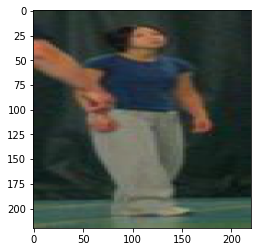

In [37]:
plt.imshow (resized_images[1813])

In [38]:
resized_poses[1600+213 , : , :]

array([[103.38830072, 163.30174283, 101.67648809,  99.96467545,
        120.50642704,  65.72842282, 206.09705863, 176.99624389,
        147.89542915, 168.43718073, 218.07974705, 228.35062284,
        163.30174283, 185.55530705],
       [181.62683544, 145.94505213, 103.89152181, 105.16587121,
        140.21047981, 173.34356431,  43.99709984,  58.65211798,
         52.28037096,  52.91754566,  65.6610397 ,  52.91754566,
         43.99709984,  24.24468408]])

predicted
[[101.23206  105.86204  100.036255 107.90234  111.554794 108.89834
  108.31668  102.284645 103.49201  115.821014 119.924774 123.63845
  109.556656 110.68956  182.07     145.4959   110.00131  111.827705
  147.26605  181.95386   90.81608   79.34982   59.357124  60.021343
   82.49164   90.49281   53.134083  31.668257]]
second
actual


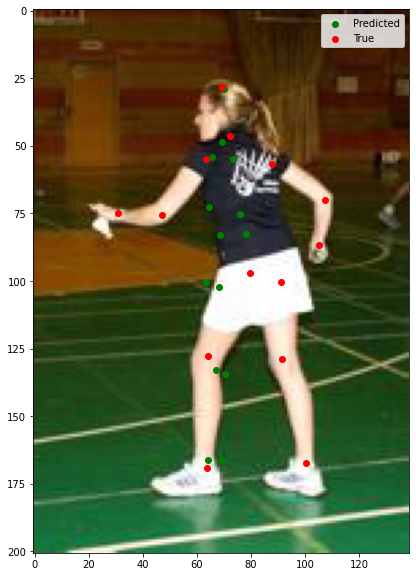

In [23]:
num = 10
dataset.compare_pose(num,DeepPose,True)
# DeepPose.model.predict(DeepPose.data['test images'][index:index+1]),220)
# plt.imshow(  dataset.data['test images'][num] +1 , aspect='auto')
# dataset.compare_pose(100,DeepPose,False)

[14.234753  13.660058  12.7361555 13.749089  13.592724  13.381226
 12.479736  12.239212  12.475034  14.305003  14.922479  14.485189
 13.381493  13.667561 ]
first
[57.3624   46.398613 36.72252  36.746334 46.37542  57.170517 27.947369
 26.358482 21.13709  21.509209 27.982643 30.51489  19.313156 12.414023]
first


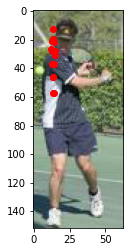

In [ ]:
DeepPose.draw_pose('images/im1310.jpg')


#others

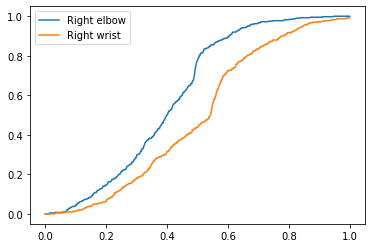

In [24]:
dataset.test_pdj(DeepPose,['Right wrist','Right elbow'])

In [ ]:
plt.plot(DeepPose.training_log['loss'],label='Training Loss')
plt.plot(DeepPose.training_log['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# tf.keras.utils.plot_model(DeepPose.model,show_shapes=True)

In [ ]:
# image,joints=dataset.augment_images()
# joints.shape

In [ ]:
dataset.data['poses'].shape